In [8]:
"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
sys.path.append('/home/mitch/util/python/')
from stargazer.stargazer import Stargazer

import mpl

import utils
import os

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'

save = False


In [9]:
os.chdir(processed)
df = pd.read_csv('data.csv')

df = df.query('Y >= 1996').query('Y <= 2000')
df['post'] = df['Y'] == 2000
df = df[~(df['Y'] == 1998)]
df

/tmp/ipykernel_2057222/2389194704.py:2: DtypeWarning: Columns (70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,terceros,pago_tar,deudas,monedas,casas,balance,otra_ero,clase_hog,nom_emp,post
9703,19960110020,1001,416,1,1565.00,0.0,1213.54,0.0,2778.54,2129.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9704,19960110030,1001,416,1,2250.00,500.0,2373.13,0.0,4623.13,3348.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9705,19960110040,1001,416,1,2850.00,500.0,987.83,0.0,3837.83,3016.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9706,19960110060,1001,1488,1,3265.00,0.0,1483.85,0.0,4748.85,5270.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9707,19960110070,1001,1488,1,51050.00,0.0,6259.55,0.0,57309.55,20178.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36551,200032190190,32042,1392,4,7874.42,0.0,1923.45,0.0,9797.87,5216.13,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2.0,2.0,True
36552,200032190200,32042,1392,4,11876.99,0.0,3352.27,0.0,15229.26,10818.09,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2.0,2.0,True
36553,200032190210,32042,1392,4,15285.00,5000.0,12034.06,0.0,27319.06,8041.58,...,0.0,0.0,0.0,0.0,0.0,2412.51,0.0,2.0,2.0,True
36554,200032190220,32042,1392,4,15592.49,2500.0,3375.53,0.0,18968.02,9584.18,...,0.0,0.0,0.0,0.0,1500.0,125.01,0.0,2.0,0.0,True


In [10]:
df.Y.unique()

array([1996, 2000])

In [11]:
cpidir = '/home/mitch/Dropbox/data/cpi/'
os.chdir(cpidir)
cpi = pd.read_csv('cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])

In [12]:
df = df.merge(cpi, on='Y', how='inner')

In [13]:
# don't include: other income
# transfers
# rental income

# do include:
# salary income
# business income

is1992 = df['Y'] == 1992

#income = ['salary_income', 'business_income', 'transfers_income']
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['income'] = df['income'] / df['cpi']
df['income'] = df['income'] / df['hh_size']
df.loc[is1992, 'income'] = df.loc[is1992, 'income'] / 1000
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
#consumption = ['consumption_food', 'consumption_clothing', 'consumption_personal', 'consumption_education']
df['consumption'] = df[consumption].sum(axis=1)
df['consumption'] = df['consumption'] / df['cpi']
df['consumption'] = df['consumption'] / df['hh_size']
df.loc[is1992, 'consumption'] = df.loc[is1992, 'consumption'] / 1000
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
df = df.query('relationship_to_hhm == 1')
df = df.query('income > 0')
df = df.query('consumption > 0')
df = df.query('age >= 25')
df = df.query('age <= 60')
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

In [15]:
consumption_to_income = ws.DescrStatsW(df['consumption'] / df['income'], weights=df['weight'])
consumption_to_income_005 = consumption_to_income.quantile(0.005)
consumption_to_income_995 = consumption_to_income.quantile(0.995)
df = df[df['consumption'] / df['income'] > consumption_to_income_005.values[0]]
df = df[df['consumption'] / df['income'] < consumption_to_income_995.values[0]]

#df['log_income']      = utils.residualize_income(df)
#df['log_consumption'] = utils.residualize_consumption(df)


#df['income'] = df['log_income'].apply(np.exp)
#df['consumption'] = df['log_consumption'].apply(np.exp)

In [16]:
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = utils.get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
    

In [17]:
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')
df

,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,otra_ero,clase_hog,nom_emp,post,cpi,income,log_income,consumption,log_consumption,decile
0,19960110020,1001,416,1,1565.00,0.0,1213.54,0.0,2778.54,2129.84,...,NaN,NaN,NaN,False,35.467989,11.031074,2.400716,9.605070,2.262291,1
1,19960110030,1001,416,1,2250.00,500.0,2373.13,0.0,4623.13,3348.84,...,NaN,NaN,NaN,False,35.467989,21.145828,3.051443,20.404220,3.015742,2
2,19960110060,1001,1488,1,3265.00,0.0,1483.85,0.0,4748.85,5270.97,...,NaN,NaN,NaN,False,35.467989,10.228315,2.325160,7.728785,2.044952,1
3,19960110070,1001,1488,1,51050.00,0.0,6259.55,0.0,57309.55,20178.74,...,NaN,NaN,NaN,False,35.467989,359.831510,5.885636,90.495686,4.505302,10
4,19960110080,1001,1488,1,2400.00,0.0,1862.80,0.0,4262.80,5281.13,...,NaN,NaN,NaN,False,35.467989,16.916663,2.828299,26.516798,3.277778,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12272,200032190090,32056,504,1,32625.01,0.0,0.00,0.0,32625.01,17905.63,...,0.0,2.0,2.0,True,63.312812,171.766235,5.146134,50.686950,3.925668,9
12273,200032190100,32056,504,1,15700.00,0.0,3458.80,0.0,19158.80,11182.78,...,0.0,2.0,2.0,True,63.312812,61.993772,4.127034,24.152852,3.184402,6
12274,200032190120,32019,4243,3,5400.00,0.0,175.97,0.0,5575.97,4982.11,...,0.0,2.0,1.0,True,63.312812,9.476755,2.248842,4.084955,1.407311,1
12275,200032190130,32019,4243,3,7020.00,0.0,500.00,0.0,7520.00,4481.56,...,0.0,2.0,0.0,True,63.312812,55.439016,4.015284,18.300403,2.906923,5


In [18]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
fam = sm.families.Gaussian(identity())

In [20]:
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = ' post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
#income_reg = 'log_income ~ ' + Z 
#income_model = smf.wls(income_reg, df, weights=df['weight']).fit()
income_model = smf.glm(income_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_income_resid'] = income_model.resid

In [21]:
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = 'post:C(education) + post:C(sex)'

consumption_reg = 'log_consumption ~ ' + Z + '+' + D
#income_reg = 'log_consumption ~ ' + Z 
#consumption_model = smf.wls(consumption_reg, df, weights=df['weight']).fit()
consumption_model = smf.glm(consumption_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_consumption_resid'] = consumption_model.resid

In [22]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        log_consumption   No. Observations:                12277
Model:                            GLM   Df Residuals:                 25838840
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                         0.21441
Method:                          IRLS   Log-Likelihood:            -1.6770e+07
Date:                Wed, 29 Nov 2023   Deviance:                   5.5401e+06
Time:                        15:09:51   Pearson chi2:                 5.54e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.6317      0.002   1416.613      0.000       2.628       2.635
C(sex)[T.2]                             0.0345      0.000     92.276      0.000       0.034       0.035
C(education)[T.low]                    -0.0184      0.000    -39.532      0.000      -0.019      -0.018
C(education)[T.medium]                  0.0093      0.000     21.181      0.000       0.008       0.010
C(location_size)[T.2]                   0.0098      0.000     38.743      0.000       0.009       0.010
C(location_size)[T.3]                   0.0143      0.000     54.656      0.000       0.014       0.015
C(decile)[T.2]                          0.4145      0.001    691.487      0.000       0.413       0.416
C(decile)[T.3]                          0.6145      0.001   1020.183      0.000       0.613       0.616
C(decile)[T.4]                          0.7924      0.001   1306.841      0.000       0.791       0.794
C(decile)[T.5]                          0.9187      0.001   1512.455      0.000       0.918       0.920
C(decile)[T.6]                          1.0453      0.001   1711.051      0.000       1.044       1.047
C(decile)[T.7]                          1.2501      0.001   2033.639      0.000       1.249       1.251
C(decile)[T.8]                          1.4439      0.001   2307.150      0.000       1.443       1.445
C(decile)[T.9]                          1.6563      0.001   2560.945      0.000       1.655       1.658
C(decile)[T.10]                         2.1887      0.001   3214.569      0.000       2.187       2.190
post[T.True]:C(decile)[1]               0.2981      0.001    365.757      0.000       0.296       0.300
post[T.True]:C(decile)[2]               0.2421      0.001    300.778      0.000       0.241       0.244
post[T.True]:C(decile)[3]               0.2131      0.001    268.760      0.000       0.212       0.215
post[T.True]:C(decile)[4]               0.1293      0.001    164.112      0.000       0.128       0.131
post[T.True]:C(decile)[5]               0.1504      0.001    194.257      0.000       0.149       0.152
post[T.True]:C(decile)[6]               0.1410      0.001    183.362      0.000       0.139       0.142
post[T.True]:C(decile)[7]               0.1377      0.001    184.454      0.000       0.136       0.139
post[T.True]:C(decile)[8]               0.1105      0.001    154.347      0.000       0.109       0.112
post[T.True]:C(decile)[9]               0.1769      0.001    264.981      0.000       0.176       0.178
post[T.True]:C(decile)[10]              0.2312      0.001    379.091      0.000       0.230       0.232
post[T.True]:C(education)[T.low]       -0.0623      0.001   -100.682      0.000      -0.064      -0.061
post[T.True]:C(education)[T.medium]    -0.0785      0.001   -133.94

In [23]:
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                12277
Model:                            GLM   Df Residuals:                 25838840
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                        0.049555
Method:                          IRLS   Log-Likelihood:             2.1549e+06
Date:                Wed, 29 Nov 2023   Deviance:                   1.2804e+06
Time:                        15:09:51   Pearson chi2:                 1.28e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.5538      0.001   2859.463      0.000       2.552       2.556
C(sex)[T.2]                            -0.0061      0.000    -34.039      0.000      -0.006      -0.006
C(education)[T.low]                    -0.0650      0.000   -289.632      0.000      -0.065      -0.065
C(education)[T.medium]                 -0.0545      0.000   -258.401      0.000      -0.055      -0.054
C(location_size)[T.2]                  -0.0127      0.000   -104.474      0.000      -0.013      -0.012
C(location_size)[T.3]                  -0.0343      0.000   -271.962      0.000      -0.035      -0.034
C(decile)[T.2]                          0.5534      0.000   1920.180      0.000       0.553       0.554
C(decile)[T.3]                          0.8415      0.000   2905.891      0.000       0.841       0.842
C(decile)[T.4]                          1.0631      0.000   3646.832      0.000       1.062       1.064
C(decile)[T.5]                          1.2709      0.000   4352.100      0.000       1.270       1.272
C(decile)[T.6]                          1.4825      0.000   5047.697      0.000       1.482       1.483
C(decile)[T.7]                          1.7078      0.000   5778.892      0.000       1.707       1.708
C(decile)[T.8]                          1.9699      0.000   6547.519      0.000       1.969       1.971
C(decile)[T.9]                          2.3641      0.000   7603.132      0.000       2.363       2.365
C(decile)[T.10]                         3.1433      0.000   9602.815      0.000       3.143       3.144
post[T.True]:C(decile)[1]               0.4092      0.000   1044.387      0.000       0.408       0.410
post[T.True]:C(decile)[2]               0.3560      0.000    920.106      0.000       0.355       0.357
post[T.True]:C(decile)[3]               0.3202      0.000    839.981      0.000       0.319       0.321
post[T.True]:C(decile)[4]               0.3291      0.000    868.623      0.000       0.328       0.330
post[T.True]:C(decile)[5]               0.3231      0.000    868.174      0.000       0.322       0.324
post[T.True]:C(decile)[6]               0.3084      0.000    834.317      0.000       0.308       0.309
post[T.True]:C(decile)[7]               0.3060      0.000    852.719      0.000       0.305       0.307
post[T.True]:C(decile)[8]               0.3190      0.000    926.617      0.000       0.318       0.320
post[T.True]:C(decile)[9]               0.3086      0.000    961.590      0.000       0.308       0.309
post[T.True]:C(decile)[10]              0.3290      0.000   1122.178      0.000       0.328       0.330
post[T.True]:C(education)[T.low]       -0.0221      0.000    -74.405      0.000      -0.023      -0.022
post[T.True]:C(education)[T.medium]    -0.0134      0.000    -47.45

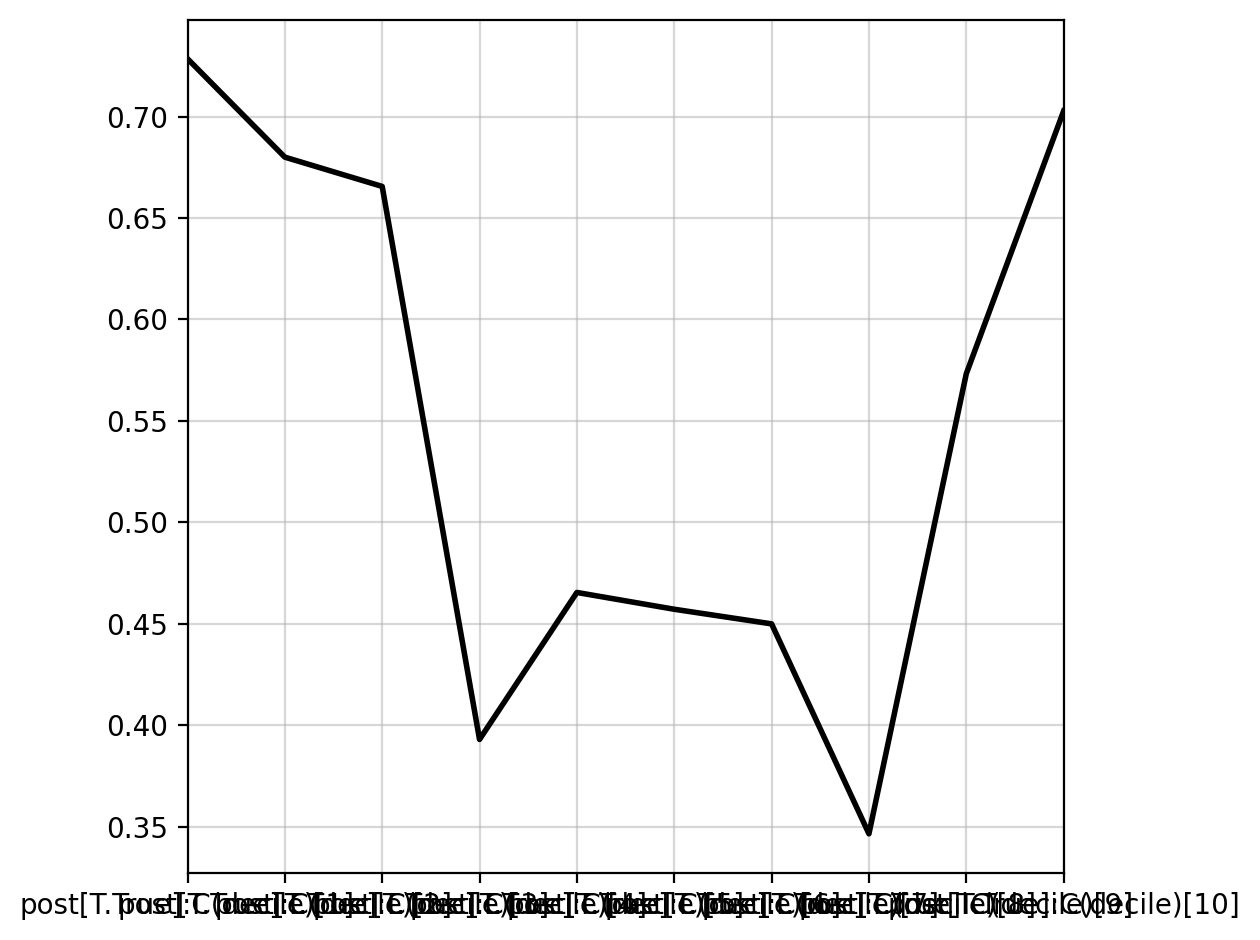

In [24]:
plt.clf()
plt.plot(consumption_model.params[params] / income_model.params[params])
plt.show()

In [25]:
nboot = 1000
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    # matters alot: double vs single resampling of the data
    # something tells me single sampling is correct
    # this is correct because: are matching the samples of the original data 
    # so should be all set 
    data_boot = df.copy().sample(len(data), weights=df['weight'], replace=True, axis=0)
    #data_boot = df.copy().sample(len(data), replace=True, axis=0)

    #consumption_model = smf.wls(consumption_reg, data_boot, weights=data_boot['weight']).fit()
    #consumption_model = smf.glm(consumption_reg, data_boot, freq_weights=data_boot['weight'], missing='drop', family=fam).fit()
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=fam).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    #income_model = smf.wls(income_reg, data_boot, weights=data_boot['weight']).fit()
    #income_model = smf.glm(income_reg, data_boot, freq_weights=data_boot['weight'],  missing='drop', family=fam).fit()
    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=fam).fit()
    dincome[boot, :] = income_model.params[params]


In [26]:
dincome

array([[0.49147725, 0.37996994, 0.35434168, ..., 0.35176221, 0.34034876,
        0.32359122],
       [0.46304255, 0.3666721 , 0.31754377, ..., 0.30567966, 0.30811464,
        0.32472153],
       [0.44495283, 0.35510783, 0.32315411, ..., 0.32070913, 0.30899022,
        0.39310791],
       ...,
       [0.35099603, 0.3518231 , 0.30841413, ..., 0.33200079, 0.3186199 ,
        0.29636773],
       [0.43633421, 0.38347031, 0.33729694, ..., 0.32986291, 0.32271777,
        0.40362475],
       [0.38565354, 0.32912221, 0.28933449, ..., 0.29604263, 0.28273238,
        0.28096217]])

In [27]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]


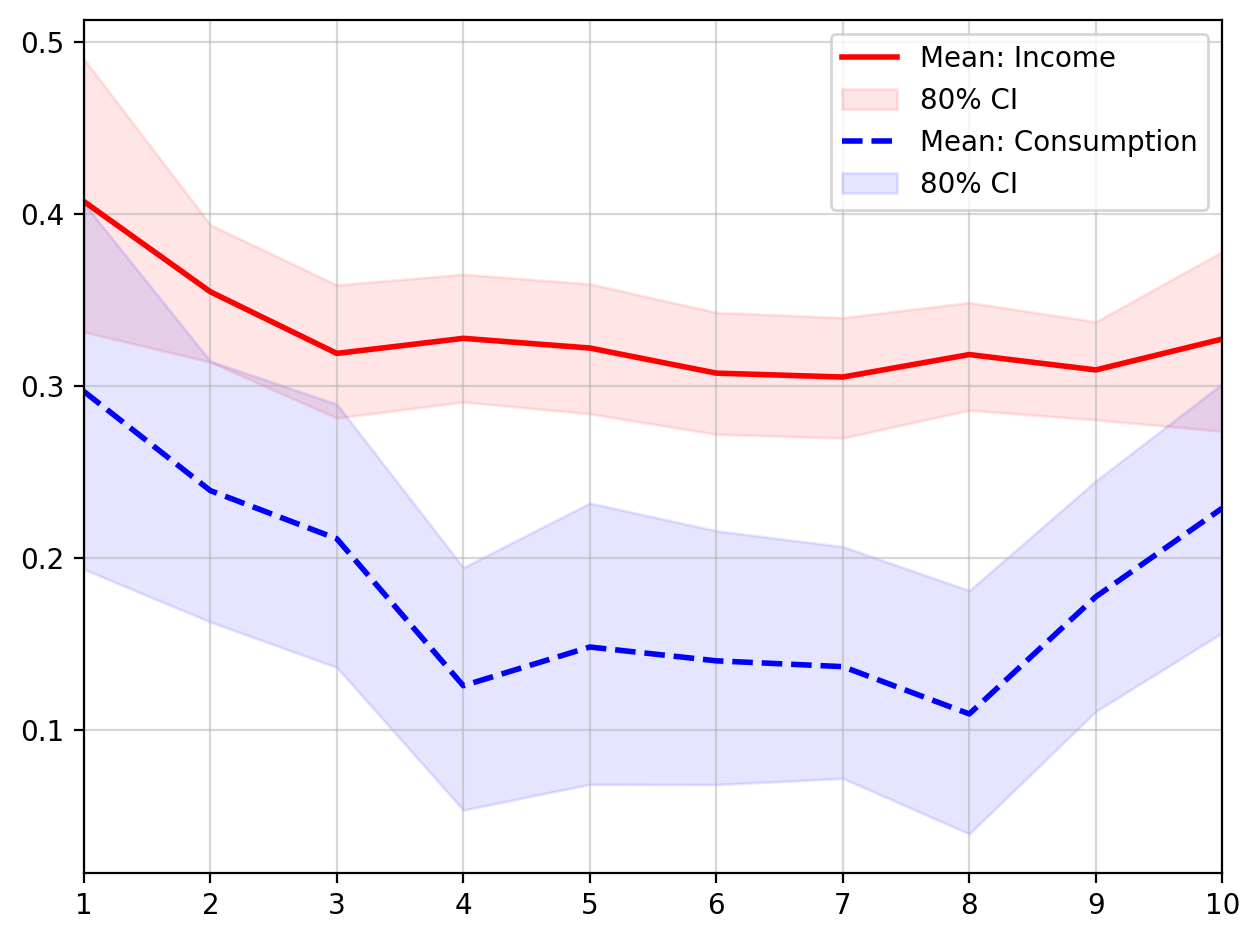

In [28]:
plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean: Income')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean: Consumption')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')

plt.legend()


#plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

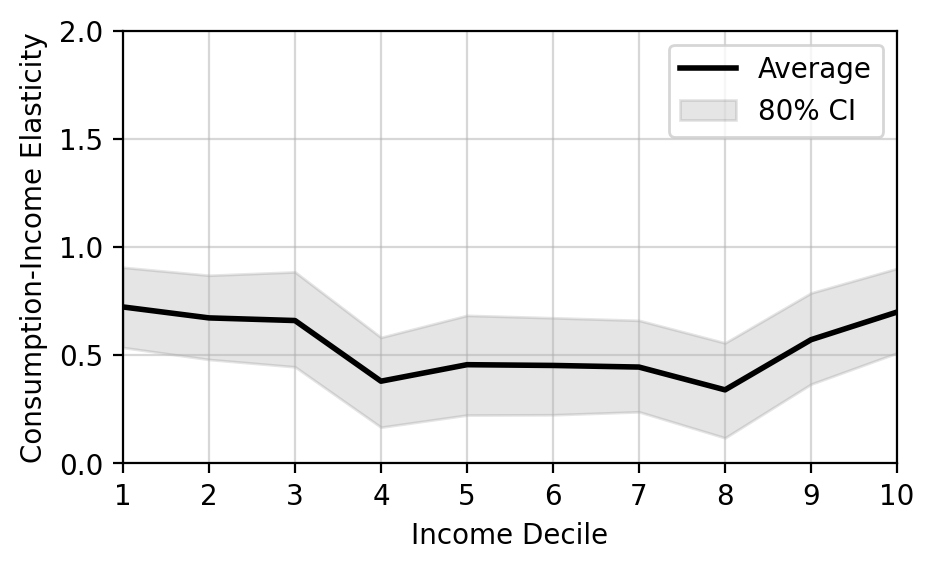

In [29]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure(figsize = mpl.set_size())

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

if save:
    os.chdir(plotdir)
#    plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)